In [1]:
# all the libs
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data Pre-Processing
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Set the root directory where "RealWaste" is located
data_dir = '/content/drive/MyDrive/Colab Notebooks/project/realwaste-main/realwaste-main/RealWaste'

# Create the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Define the transformation pipeline
"""transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])"""

# Augmentation 1
"""transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with variable scale
    transforms.RandomHorizontalFlip(),                    # Flip images horizontally at random
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])"""

# Augmentation 2 (BEST)
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Augmentation 3
"""transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])"""

# Augmentation 4
"""transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # New augmentation
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])"""

# Augmentation 5
"""transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),

    # small translations + scale + shear
    transforms.RandomAffine(
        degrees=0,                  # we already have rotation
        translate=(0.1, 0.1),       # shift up to ±10% in x/y
        scale=(0.9, 1.1),           # zoom in/out by ±10%
        shear=10                    # shear by up to ±10°
    ),

    transforms.RandomRotation(20),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),

    # simulate slight focus/defocus
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2.0)),

    # adjust contrast on the fly
    transforms.RandomAutocontrast(p=0.5),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])"""

# Augmentation 6
"""transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])"""

# Augmentation 7
"""transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])"""

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transform(x), y
    def __len__(self):
        return len(self.subset)

# No transform in ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# calculate the sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% train
test_size = total_size - train_size

# Split
db_train, db_test = random_split(dataset, [train_size, test_size])

# Wrap with transforms
db_train = SubsetWithTransform(db_train, transform_train)
db_test = SubsetWithTransform(db_test, transform_test)

# Define the data loaders
loader_train = DataLoader(db_train, batch_size=32, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=32, shuffle=False)

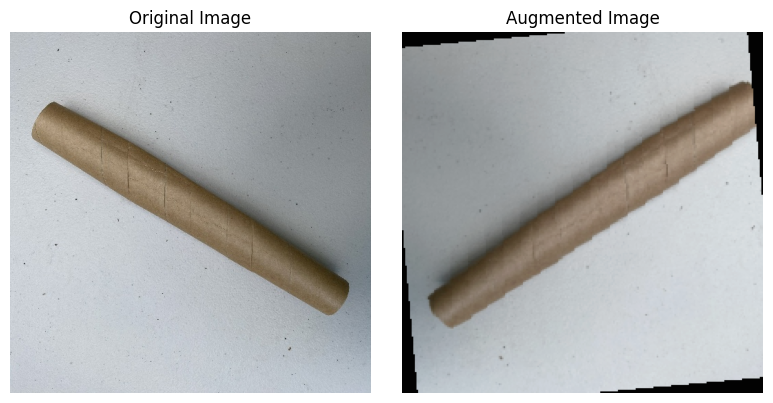

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image

# Load a raw image (no transform applied)
img_path, _ = dataset.samples[0]  # Grab the path of the first image
original_image = Image.open(img_path).convert('RGB')

# Apply augmentation to the same image
augmented_image = transform_train(original_image)

# Unnormalize for visualization
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return tensor * std + mean

# Convert augmented tensor back to PIL image for display
augmented_image_display = TF.to_pil_image(unnormalize(augmented_image).clamp(0,1))

# Plot
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image_display)
plt.title("Augmented Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# training utils
from torch import nn
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

def fit_one_epoch(model, opt, loader):
    model.train(True)
    loss = nn.CrossEntropyLoss()
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()

        l.backward()
        opt.step()
        opt.zero_grad()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    model.train(False)
    loss = nn.CrossEntropyLoss()
    accuracies, losses = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        l = loss(pred, labels)

        accuracies.append(acc.detach().item())
        losses.append(l.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_val, epochs=50, opt=None):
    assert opt is not None
    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = [], [], [], []
    for epoch in range(epochs):
        val_l, val_acc = eval(model, loader_val)
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}  Val Loss = {val_l:.3f}   Train Acc = {tr_acc:.3f}   Val Acc = {val_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_val_loss.append(val_l)
        hist_tr_acc.append(tr_acc)
        hist_val_acc.append(val_acc)
    return hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc

def plot_training_history(hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc):
    plt.subplot(1, 2, 1)
    plt.plot(hist_tr_acc, label='train accuracy')
    plt.plot(hist_val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist_tr_loss, label='train loss')
    plt.plot(hist_val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

Using cuda device


In [ ]:
# Train
def train(model, loader_train, loader_test, epochs=5, lr=0.01):

  # Define the optimizer
  opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

  # Fit the model to our data
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # eval
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [ ]:
# Fine tuning
def fine_tuning(model, loader_train, loader_test, epochs=2, lr=0.001):

    # Unfreeze the entire model for fine-tuning
  for p in model.parameters():
      p.requires_grad = True

  # Define optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  opt = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

  # Training
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # Testing
  loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

@torch.no_grad()
def evaluate_metrics(model, loader):
    model.eval()
    y_pred = []
    y_true = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    # Unique class labels from the dataset
    labels_list = list(range(len(dataset.classes)))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    cm_normalized = cm / cm.sum(axis=0, keepdims=True)  # Normalize by column (actual label)

    # Confusion matrix heatmap (x = Actual, y = Predicted)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        cm_normalized.T, annot=cm.T, fmt='d', cmap="Blues",
        xticklabels=dataset.classes, yticklabels=dataset.classes,
        cbar_kws={"label": "Percentage of Actual Label"}
    )
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.xticks(rotation=45, ha="right")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=labels_list, average=None)
    recall = recall_score(y_true, y_pred, labels=labels_list, average=None)
    f1 = f1_score(y_true, y_pred, labels=labels_list, average=None)

    print(f"\nAccuracy: {acc:.4f}")
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        class_name = dataset.classes[i]
        print(f"Class {i} ({class_name}): Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}")

    # Macro-averaged scores
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\nMacro-Averaged Metrics:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall:    {macro_recall:.4f}")
    print(f"F1 Score:  {macro_f1:.4f}")

In [ ]:
# train-fine-tune-pipeline
def pipeline(model):
  global db_train, db_test, loader_train, loader_test

  # Define the model for 9-class classification
  if hasattr(model, 'classifier'): # DenseNet121
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, 9)

  # Move entire model to device
  model = model.to(device)

  # Freeze feature extractor
  for param in model.features.parameters():
      param.requires_grad = False

  # Test the model with one batch to confirm it works
  image_batch, label_batch = db_train[0]
  feature_batch = model(image_batch[None].to(device))

  # Train the model
  train(model, loader_train, loader_test, epochs=8, lr = 0.01)

  # fine tune
  fine_tuning(model, loader_train, loader_test, epochs=10, lr=0.001)

  return model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 118/118 [00:48<00:00,  2.41it/s]

Finished epoch 0 of 8: Train Loss = 1.089  Val Loss = 2.261   Train Acc = 0.624   Val Acc = 0.099



100%|██████████| 118/118 [00:50<00:00,  2.35it/s]

Finished epoch 1 of 8: Train Loss = 0.615  Val Loss = 0.697   Train Acc = 0.788   Val Acc = 0.759



100%|██████████| 118/118 [00:49<00:00,  2.39it/s]

Finished epoch 2 of 8: Train Loss = 0.531  Val Loss = 0.594   Train Acc = 0.814   Val Acc = 0.799



100%|██████████| 118/118 [00:48<00:00,  2.43it/s]

Finished epoch 3 of 8: Train Loss = 0.450  Val Loss = 0.613   Train Acc = 0.841   Val Acc = 0.789



100%|██████████| 118/118 [00:49<00:00,  2.40it/s]

Finished epoch 4 of 8: Train Loss = 0.472  Val Loss = 0.601   Train Acc = 0.832   Val Acc = 0.794



100%|██████████| 118/118 [00:49<00:00,  2.39it/s]

Finished epoch 5 of 8: Train Loss = 0.421  Val Loss = 0.572   Train Acc = 0.851   Val Acc = 0.804



100%|██████████| 118/118 [00:48<00:00,  2.43it/s]

Finished epoch 6 of 8: Train Loss = 0.390  Val Loss = 0.634   Train Acc = 0.858   Val Acc = 0.802



100%|██████████| 118/118 [00:49<00:00,  2.39it/s]

Finished epoch 7 of 8: Train Loss = 0.344  Val Loss = 0.629   Train Acc = 0.876   Val Acc = 0.793



100%|██████████| 30/30 [00:12<00:00,  2.46it/s]


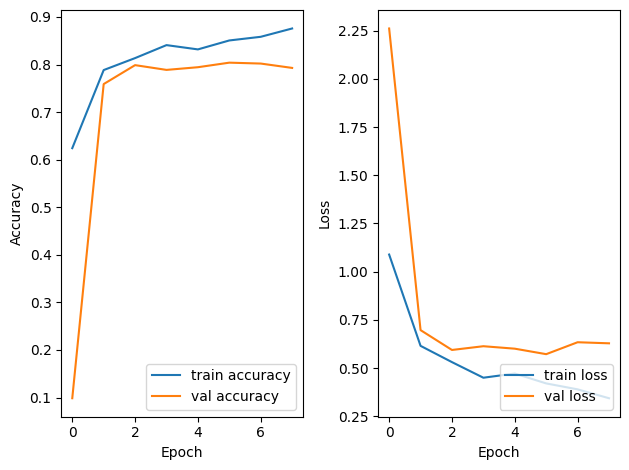

Test accuracy: 79.33%
Test loss: 0.589


100%|██████████| 118/118 [01:13<00:00,  1.60it/s]

Finished epoch 0 of 10: Train Loss = 0.346  Val Loss = 0.589   Train Acc = 0.879   Val Acc = 0.793



100%|██████████| 118/118 [01:14<00:00,  1.59it/s]

Finished epoch 1 of 10: Train Loss = 0.099  Val Loss = 0.484   Train Acc = 0.968   Val Acc = 0.847



100%|██████████| 118/118 [01:14<00:00,  1.59it/s]

Finished epoch 2 of 10: Train Loss = 0.033  Val Loss = 0.383   Train Acc = 0.992   Val Acc = 0.878



100%|██████████| 118/118 [01:13<00:00,  1.60it/s]

Finished epoch 3 of 10: Train Loss = 0.019  Val Loss = 0.332   Train Acc = 0.997   Val Acc = 0.896



100%|██████████| 118/118 [01:13<00:00,  1.60it/s]

Finished epoch 4 of 10: Train Loss = 0.009  Val Loss = 0.315   Train Acc = 0.999   Val Acc = 0.902



100%|██████████| 118/118 [01:13<00:00,  1.61it/s]

Finished epoch 5 of 10: Train Loss = 0.006  Val Loss = 0.322   Train Acc = 1.000   Val Acc = 0.912



100%|██████████| 118/118 [01:14<00:00,  1.59it/s]

Finished epoch 6 of 10: Train Loss = 0.006  Val Loss = 0.311   Train Acc = 0.999   Val Acc = 0.914



100%|██████████| 118/118 [01:13<00:00,  1.61it/s]

Finished epoch 7 of 10: Train Loss = 0.005  Val Loss = 0.305   Train Acc = 1.000   Val Acc = 0.911



100%|██████████| 118/118 [01:13<00:00,  1.60it/s]

Finished epoch 8 of 10: Train Loss = 0.004  Val Loss = 0.313   Train Acc = 1.000   Val Acc = 0.916



100%|██████████| 118/118 [01:13<00:00,  1.61it/s]

Finished epoch 9 of 10: Train Loss = 0.003  Val Loss = 0.316   Train Acc = 1.000   Val Acc = 0.914



100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


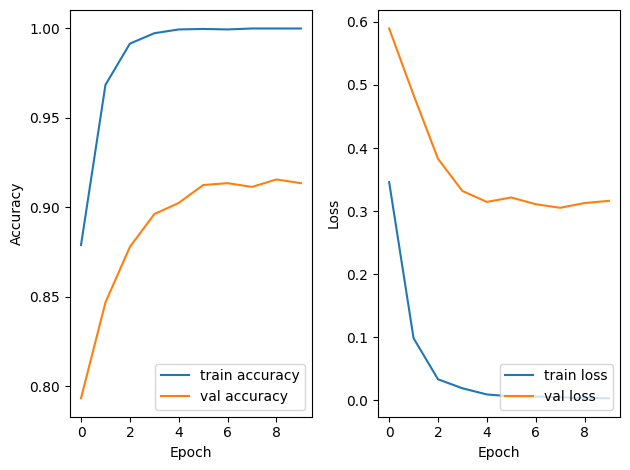

Test accuracy: 91.12%
Test loss: 0.307


TypeError: evaluate_metrics() missing 2 required positional arguments: 'dataset' and 'device'

In [ ]:
# densenet121
dn = pipeline(models.densenet121(pretrained=True))

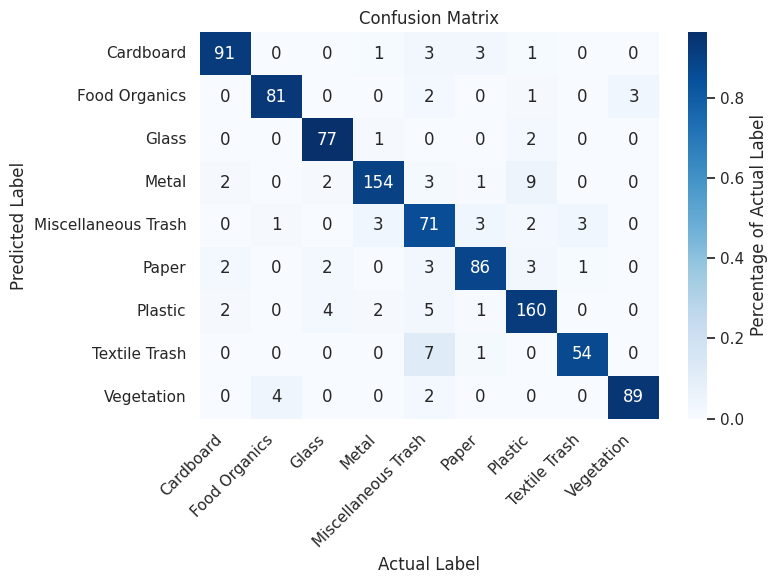


Accuracy: 0.9103
Class 0 (Cardboard): Precision: 0.9192, Recall: 0.9381, F1 Score: 0.9286
Class 1 (Food Organics): Precision: 0.9310, Recall: 0.9419, F1 Score: 0.9364
Class 2 (Glass): Precision: 0.9625, Recall: 0.9059, F1 Score: 0.9333
Class 3 (Metal): Precision: 0.9006, Recall: 0.9565, F1 Score: 0.9277
Class 4 (Miscellaneous Trash): Precision: 0.8554, Recall: 0.7396, F1 Score: 0.7933
Class 5 (Paper): Precision: 0.8866, Recall: 0.9053, F1 Score: 0.8958
Class 6 (Plastic): Precision: 0.9195, Recall: 0.8989, F1 Score: 0.9091
Class 7 (Textile Trash): Precision: 0.8710, Recall: 0.9310, F1 Score: 0.9000
Class 8 (Vegetation): Precision: 0.9368, Recall: 0.9674, F1 Score: 0.9519

Macro-Averaged Metrics:
Precision: 0.9092
Recall:    0.9094
F1 Score:  0.9085


In [ ]:
# evaluate dense121
evaluate_metrics(dn, loader_test)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 129MB/s]
100%|██████████| 119/119 [44:15<00:00, 22.31s/it]

Finished epoch 0 of 8: Train Loss = 1.070  Val Loss = 2.240   Train Acc = 0.632   Val Acc = 0.112



100%|██████████| 119/119 [00:59<00:00,  1.99it/s]

Finished epoch 1 of 8: Train Loss = 0.699  Val Loss = 0.853   Train Acc = 0.754   Val Acc = 0.725



100%|██████████| 119/119 [00:50<00:00,  2.37it/s]

Finished epoch 2 of 8: Train Loss = 0.533  Val Loss = 0.694   Train Acc = 0.811   Val Acc = 0.759



100%|██████████| 119/119 [00:49<00:00,  2.38it/s]

Finished epoch 3 of 8: Train Loss = 0.522  Val Loss = 0.738   Train Acc = 0.814   Val Acc = 0.773



100%|██████████| 119/119 [00:50<00:00,  2.35it/s]

Finished epoch 4 of 8: Train Loss = 0.509  Val Loss = 0.629   Train Acc = 0.820   Val Acc = 0.791



100%|██████████| 119/119 [00:49<00:00,  2.39it/s]

Finished epoch 5 of 8: Train Loss = 0.465  Val Loss = 0.546   Train Acc = 0.837   Val Acc = 0.824



100%|██████████| 119/119 [00:50<00:00,  2.34it/s]

Finished epoch 6 of 8: Train Loss = 0.427  Val Loss = 0.535   Train Acc = 0.849   Val Acc = 0.823



100%|██████████| 119/119 [00:50<00:00,  2.35it/s]

Finished epoch 7 of 8: Train Loss = 0.463  Val Loss = 0.686   Train Acc = 0.838   Val Acc = 0.793



100%|██████████| 30/30 [00:11<00:00,  2.51it/s]


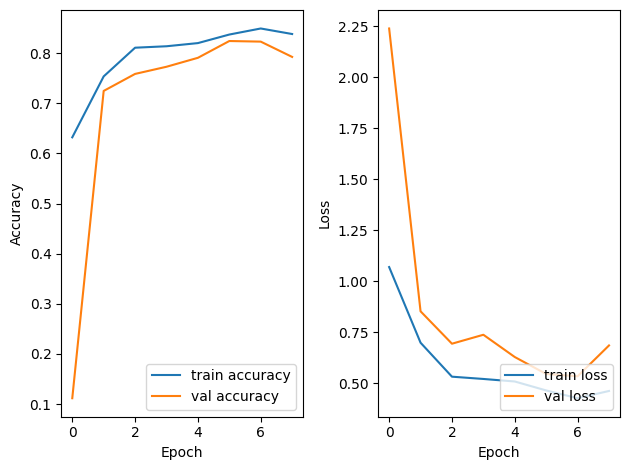

Test accuracy: 81.74%
Test loss: 0.599


100%|██████████| 119/119 [01:14<00:00,  1.59it/s]

Finished epoch 0 of 10: Train Loss = 0.394  Val Loss = 0.599   Train Acc = 0.862   Val Acc = 0.817



100%|██████████| 119/119 [01:14<00:00,  1.61it/s]

Finished epoch 1 of 10: Train Loss = 0.158  Val Loss = 0.434   Train Acc = 0.945   Val Acc = 0.858



100%|██████████| 119/119 [01:15<00:00,  1.58it/s]

Finished epoch 2 of 10: Train Loss = 0.083  Val Loss = 0.348   Train Acc = 0.974   Val Acc = 0.880



100%|██████████| 119/119 [01:15<00:00,  1.59it/s]

Finished epoch 3 of 10: Train Loss = 0.055  Val Loss = 0.305   Train Acc = 0.985   Val Acc = 0.889



100%|██████████| 119/119 [01:15<00:00,  1.58it/s]

Finished epoch 4 of 10: Train Loss = 0.035  Val Loss = 0.269   Train Acc = 0.990   Val Acc = 0.914



100%|██████████| 119/119 [01:13<00:00,  1.61it/s]

Finished epoch 5 of 10: Train Loss = 0.026  Val Loss = 0.261   Train Acc = 0.994   Val Acc = 0.909



100%|██████████| 119/119 [01:14<00:00,  1.59it/s]

Finished epoch 6 of 10: Train Loss = 0.018  Val Loss = 0.252   Train Acc = 0.997   Val Acc = 0.924



100%|██████████| 119/119 [01:14<00:00,  1.60it/s]

Finished epoch 7 of 10: Train Loss = 0.018  Val Loss = 0.266   Train Acc = 0.996   Val Acc = 0.910



100%|██████████| 119/119 [01:14<00:00,  1.60it/s]

Finished epoch 8 of 10: Train Loss = 0.013  Val Loss = 0.274   Train Acc = 0.998   Val Acc = 0.910



100%|██████████| 119/119 [01:14<00:00,  1.60it/s]

Finished epoch 9 of 10: Train Loss = 0.012  Val Loss = 0.239   Train Acc = 0.999   Val Acc = 0.917



100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


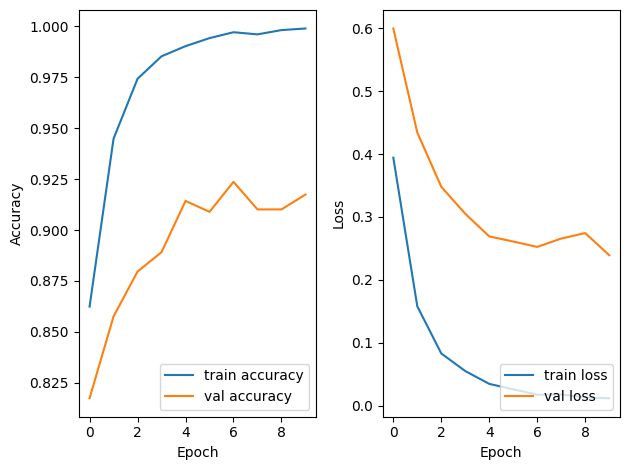

Test accuracy: 91.01%
Test loss: 0.269


In [ ]:
# densenet121 w/ augmentation 1
dn1 = pipeline(models.densenet121(pretrained=True))

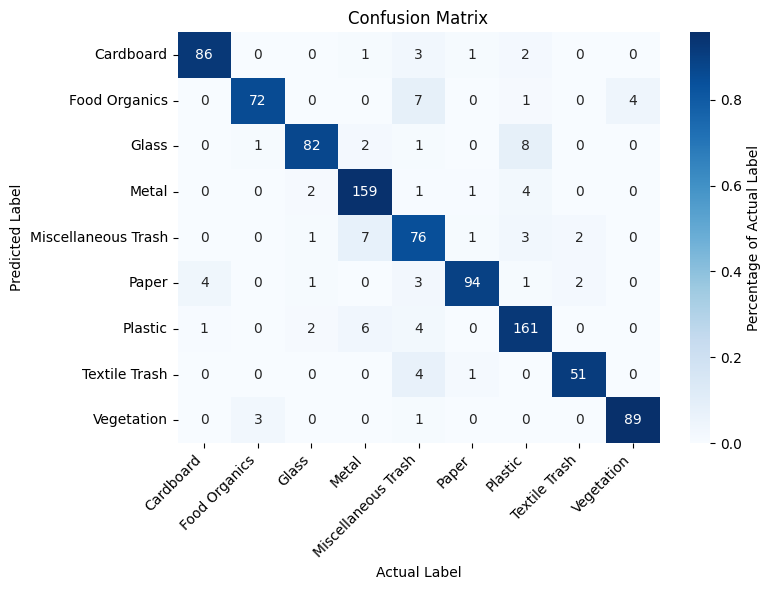


Accuracy: 0.9100
Class 0 (Cardboard): Precision: 0.9247, Recall: 0.9451, F1 Score: 0.9348
Class 1 (Food Organics): Precision: 0.8571, Recall: 0.9474, F1 Score: 0.9000
Class 2 (Glass): Precision: 0.8723, Recall: 0.9318, F1 Score: 0.9011
Class 3 (Metal): Precision: 0.9521, Recall: 0.9086, F1 Score: 0.9298
Class 4 (Miscellaneous Trash): Precision: 0.8444, Recall: 0.7600, F1 Score: 0.8000
Class 5 (Paper): Precision: 0.8952, Recall: 0.9592, F1 Score: 0.9261
Class 6 (Plastic): Precision: 0.9253, Recall: 0.8944, F1 Score: 0.9096
Class 7 (Textile Trash): Precision: 0.9107, Recall: 0.9273, F1 Score: 0.9189
Class 8 (Vegetation): Precision: 0.9570, Recall: 0.9570, F1 Score: 0.9570

Macro-Averaged Metrics:
Precision: 0.9043
Recall:    0.9145
F1 Score:  0.9086


In [ ]:
# evaluate dense121 w/ augmentation 1
evaluate_metrics(dn1, loader_test)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 166MB/s]
100%|██████████| 119/119 [22:15<00:00, 11.22s/it]

Finished epoch 0 of 8: Train Loss = 1.218  Val Loss = 2.426   Train Acc = 0.576   Val Acc = 0.065



100%|██████████| 119/119 [01:14<00:00,  1.59it/s]

Finished epoch 1 of 8: Train Loss = 0.828  Val Loss = 0.764   Train Acc = 0.712   Val Acc = 0.732



100%|██████████| 119/119 [01:09<00:00,  1.70it/s]

Finished epoch 2 of 8: Train Loss = 0.832  Val Loss = 0.759   Train Acc = 0.713   Val Acc = 0.748



100%|██████████| 119/119 [01:09<00:00,  1.70it/s]

Finished epoch 3 of 8: Train Loss = 0.762  Val Loss = 0.675   Train Acc = 0.746   Val Acc = 0.777



100%|██████████| 119/119 [01:10<00:00,  1.70it/s]

Finished epoch 4 of 8: Train Loss = 0.678  Val Loss = 0.682   Train Acc = 0.759   Val Acc = 0.775



100%|██████████| 119/119 [01:10<00:00,  1.69it/s]

Finished epoch 5 of 8: Train Loss = 0.724  Val Loss = 0.669   Train Acc = 0.761   Val Acc = 0.772



100%|██████████| 119/119 [01:09<00:00,  1.71it/s]

Finished epoch 6 of 8: Train Loss = 0.693  Val Loss = 0.663   Train Acc = 0.765   Val Acc = 0.787



100%|██████████| 119/119 [01:09<00:00,  1.70it/s]

Finished epoch 7 of 8: Train Loss = 0.680  Val Loss = 0.725   Train Acc = 0.762   Val Acc = 0.776



100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


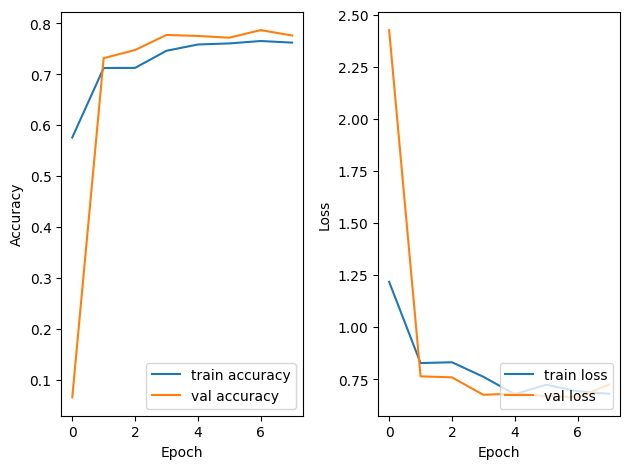

Test accuracy: 78.27%
Test loss: 0.672


100%|██████████| 119/119 [01:34<00:00,  1.25it/s]

Finished epoch 0 of 10: Train Loss = 0.588  Val Loss = 0.672   Train Acc = 0.798   Val Acc = 0.783



100%|██████████| 119/119 [01:34<00:00,  1.26it/s]

Finished epoch 1 of 10: Train Loss = 0.328  Val Loss = 0.569   Train Acc = 0.886   Val Acc = 0.821



100%|██████████| 119/119 [01:38<00:00,  1.21it/s]

Finished epoch 2 of 10: Train Loss = 0.226  Val Loss = 0.413   Train Acc = 0.914   Val Acc = 0.865



100%|██████████| 119/119 [01:40<00:00,  1.19it/s]

Finished epoch 3 of 10: Train Loss = 0.135  Val Loss = 0.347   Train Acc = 0.950   Val Acc = 0.886



100%|██████████| 119/119 [01:41<00:00,  1.17it/s]

Finished epoch 4 of 10: Train Loss = 0.106  Val Loss = 0.305   Train Acc = 0.965   Val Acc = 0.896



100%|██████████| 119/119 [01:37<00:00,  1.22it/s]

Finished epoch 5 of 10: Train Loss = 0.079  Val Loss = 0.275   Train Acc = 0.973   Val Acc = 0.910



100%|██████████| 119/119 [01:39<00:00,  1.19it/s]

Finished epoch 6 of 10: Train Loss = 0.060  Val Loss = 0.292   Train Acc = 0.981   Val Acc = 0.911



100%|██████████| 119/119 [01:40<00:00,  1.18it/s]

Finished epoch 7 of 10: Train Loss = 0.052  Val Loss = 0.264   Train Acc = 0.984   Val Acc = 0.913



100%|██████████| 119/119 [01:38<00:00,  1.21it/s]

Finished epoch 8 of 10: Train Loss = 0.042  Val Loss = 0.274   Train Acc = 0.988   Val Acc = 0.914



100%|██████████| 119/119 [01:34<00:00,  1.26it/s]

Finished epoch 9 of 10: Train Loss = 0.037  Val Loss = 0.275   Train Acc = 0.990   Val Acc = 0.926



100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


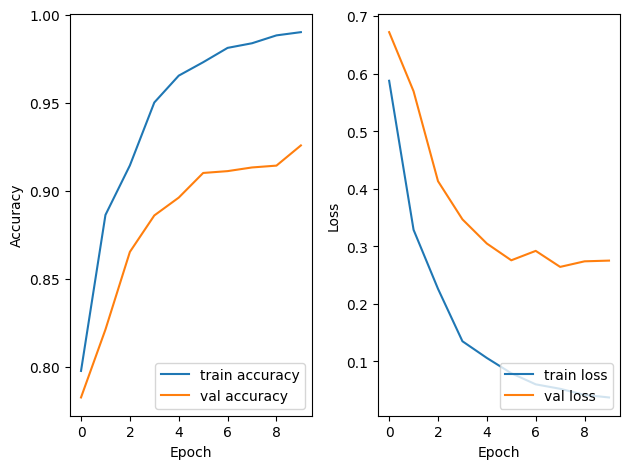

Test accuracy: 92.05%
Test loss: 0.271


In [ ]:
# densenet121 w/ augmentation 2
dn2 = pipeline(models.densenet121(pretrained=True))

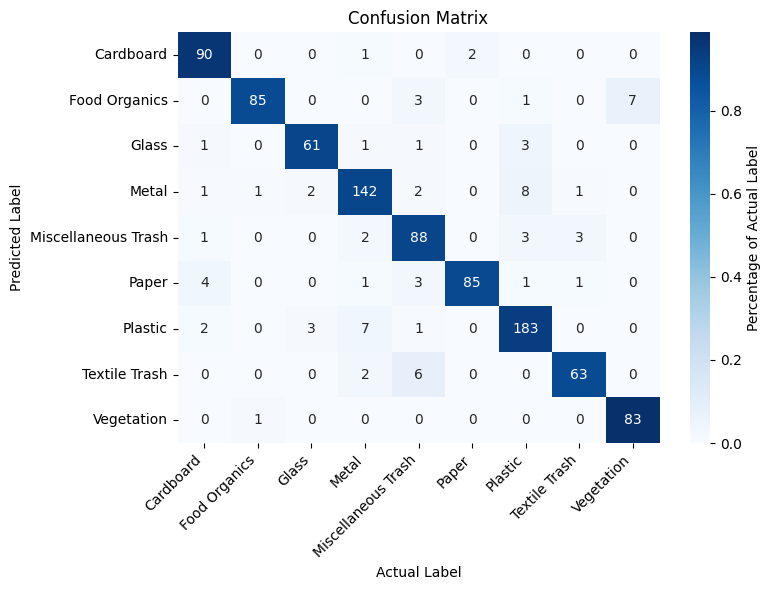


Accuracy: 0.9205
Class 0 (Cardboard): Precision: 0.9677, Recall: 0.9091, F1 Score: 0.9375
Class 1 (Food Organics): Precision: 0.8854, Recall: 0.9770, F1 Score: 0.9290
Class 2 (Glass): Precision: 0.9104, Recall: 0.9242, F1 Score: 0.9173
Class 3 (Metal): Precision: 0.9045, Recall: 0.9103, F1 Score: 0.9073
Class 4 (Miscellaneous Trash): Precision: 0.9072, Recall: 0.8462, F1 Score: 0.8756
Class 5 (Paper): Precision: 0.8947, Recall: 0.9770, F1 Score: 0.9341
Class 6 (Plastic): Precision: 0.9337, Recall: 0.9196, F1 Score: 0.9266
Class 7 (Textile Trash): Precision: 0.8873, Recall: 0.9265, F1 Score: 0.9065
Class 8 (Vegetation): Precision: 0.9881, Recall: 0.9222, F1 Score: 0.9540

Macro-Averaged Metrics:
Precision: 0.9199
Recall:    0.9236
F1 Score:  0.9209


In [ ]:
# evaluate dense121 w/ augmentation 2
evaluate_metrics(dn2, loader_test)

100%|██████████| 119/119 [14:58<00:00,  7.55s/it]

Finished epoch 0 of 8: Train Loss = 1.447  Val Loss = 2.393   Train Acc = 0.501   Val Acc = 0.133



100%|██████████| 119/119 [01:17<00:00,  1.53it/s]

Finished epoch 1 of 8: Train Loss = 0.998  Val Loss = 1.058   Train Acc = 0.664   Val Acc = 0.624



100%|██████████| 119/119 [01:12<00:00,  1.63it/s]

Finished epoch 2 of 8: Train Loss = 0.913  Val Loss = 0.777   Train Acc = 0.681   Val Acc = 0.736



100%|██████████| 119/119 [01:13<00:00,  1.62it/s]

Finished epoch 3 of 8: Train Loss = 0.860  Val Loss = 0.722   Train Acc = 0.700   Val Acc = 0.756



100%|██████████| 119/119 [01:13<00:00,  1.61it/s]

Finished epoch 4 of 8: Train Loss = 0.868  Val Loss = 0.955   Train Acc = 0.707   Val Acc = 0.714



100%|██████████| 119/119 [01:13<00:00,  1.61it/s]

Finished epoch 5 of 8: Train Loss = 0.924  Val Loss = 0.679   Train Acc = 0.704   Val Acc = 0.761



100%|██████████| 119/119 [01:13<00:00,  1.61it/s]

Finished epoch 6 of 8: Train Loss = 0.870  Val Loss = 0.804   Train Acc = 0.715   Val Acc = 0.745



100%|██████████| 119/119 [01:13<00:00,  1.63it/s]

Finished epoch 7 of 8: Train Loss = 0.873  Val Loss = 0.752   Train Acc = 0.709   Val Acc = 0.750



100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


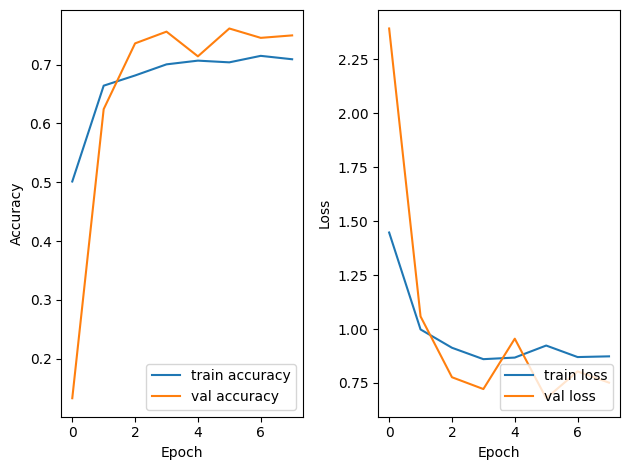

Test accuracy: 76.50%
Test loss: 0.716


100%|██████████| 119/119 [01:38<00:00,  1.20it/s]

Finished epoch 0 of 10: Train Loss = 0.752  Val Loss = 0.716   Train Acc = 0.748   Val Acc = 0.765



100%|██████████| 119/119 [01:39<00:00,  1.19it/s]

Finished epoch 1 of 10: Train Loss = 0.498  Val Loss = 0.580   Train Acc = 0.830   Val Acc = 0.819



100%|██████████| 119/119 [01:39<00:00,  1.20it/s]

Finished epoch 2 of 10: Train Loss = 0.383  Val Loss = 0.445   Train Acc = 0.865   Val Acc = 0.856



100%|██████████| 119/119 [01:39<00:00,  1.20it/s]

Finished epoch 3 of 10: Train Loss = 0.305  Val Loss = 0.366   Train Acc = 0.896   Val Acc = 0.878



100%|██████████| 119/119 [01:38<00:00,  1.21it/s]

Finished epoch 4 of 10: Train Loss = 0.234  Val Loss = 0.342   Train Acc = 0.917   Val Acc = 0.892



100%|██████████| 119/119 [01:38<00:00,  1.20it/s]

Finished epoch 5 of 10: Train Loss = 0.214  Val Loss = 0.301   Train Acc = 0.927   Val Acc = 0.894



100%|██████████| 119/119 [01:38<00:00,  1.20it/s]

Finished epoch 6 of 10: Train Loss = 0.182  Val Loss = 0.274   Train Acc = 0.940   Val Acc = 0.908



100%|██████████| 119/119 [01:38<00:00,  1.21it/s]

Finished epoch 7 of 10: Train Loss = 0.159  Val Loss = 0.273   Train Acc = 0.945   Val Acc = 0.917



100%|██████████| 119/119 [01:38<00:00,  1.21it/s]

Finished epoch 8 of 10: Train Loss = 0.130  Val Loss = 0.284   Train Acc = 0.955   Val Acc = 0.920



100%|██████████| 119/119 [01:37<00:00,  1.22it/s]

Finished epoch 9 of 10: Train Loss = 0.114  Val Loss = 0.275   Train Acc = 0.959   Val Acc = 0.921



100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


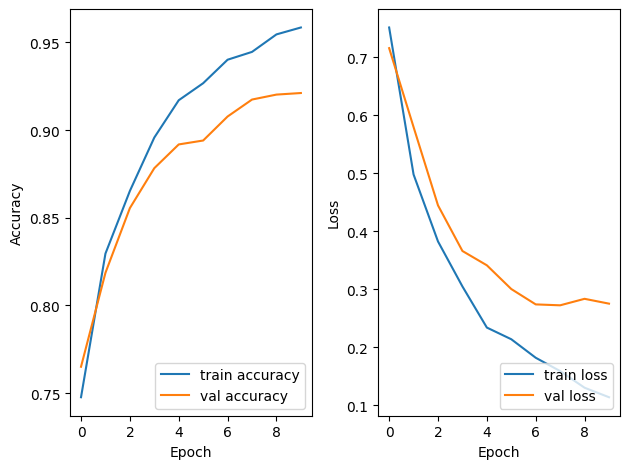

Test accuracy: 91.29%
Test loss: 0.296


In [ ]:
# densenet121 w/ augmentation 3
dn3 = pipeline(models.densenet121(pretrained=True))

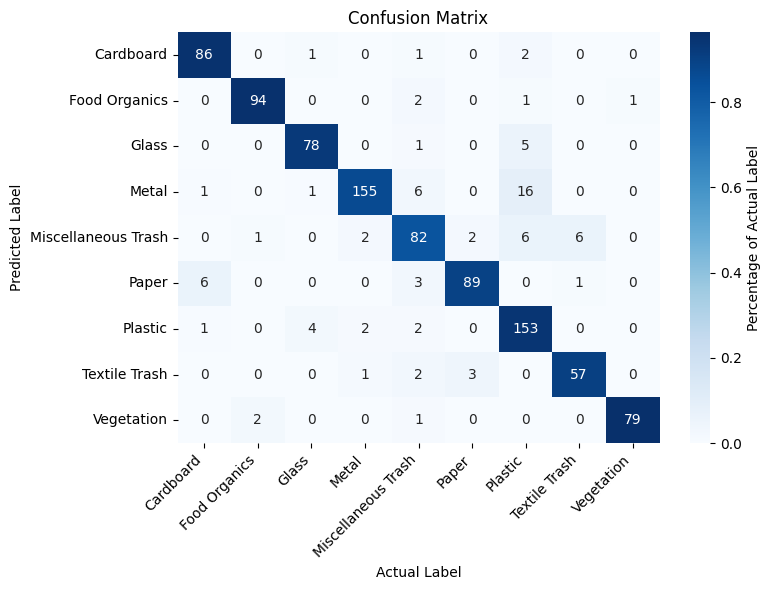


Accuracy: 0.9132
Class 0 (Cardboard): Precision: 0.9556, Recall: 0.9149, F1 Score: 0.9348
Class 1 (Food Organics): Precision: 0.9592, Recall: 0.9691, F1 Score: 0.9641
Class 2 (Glass): Precision: 0.9286, Recall: 0.9286, F1 Score: 0.9286
Class 3 (Metal): Precision: 0.8659, Recall: 0.9688, F1 Score: 0.9145
Class 4 (Miscellaneous Trash): Precision: 0.8283, Recall: 0.8200, F1 Score: 0.8241
Class 5 (Paper): Precision: 0.8990, Recall: 0.9468, F1 Score: 0.9223
Class 6 (Plastic): Precision: 0.9444, Recall: 0.8361, F1 Score: 0.8870
Class 7 (Textile Trash): Precision: 0.9048, Recall: 0.8906, F1 Score: 0.8976
Class 8 (Vegetation): Precision: 0.9634, Recall: 0.9875, F1 Score: 0.9753

Macro-Averaged Metrics:
Precision: 0.9166
Recall:    0.9180
F1 Score:  0.9165


In [ ]:
# evaluate dense121 w/ augmentation 3
evaluate_metrics(dn3, loader_test)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 209MB/s]
100%|██████████| 119/119 [44:07<00:00, 22.25s/it]

Finished epoch 0 of 8: Train Loss = 1.285  Val Loss = 2.340   Train Acc = 0.551   Val Acc = 0.086



100%|██████████| 119/119 [01:10<00:00,  1.68it/s]

Finished epoch 1 of 8: Train Loss = 0.980  Val Loss = 1.193   Train Acc = 0.668   Val Acc = 0.612



100%|██████████| 119/119 [01:00<00:00,  1.98it/s]

Finished epoch 2 of 8: Train Loss = 0.803  Val Loss = 0.864   Train Acc = 0.723   Val Acc = 0.688



100%|██████████| 119/119 [01:00<00:00,  1.97it/s]

Finished epoch 3 of 8: Train Loss = 0.812  Val Loss = 0.789   Train Acc = 0.726   Val Acc = 0.725



100%|██████████| 119/119 [01:00<00:00,  1.98it/s]

Finished epoch 4 of 8: Train Loss = 0.818  Val Loss = 0.770   Train Acc = 0.733   Val Acc = 0.743



100%|██████████| 119/119 [01:01<00:00,  1.93it/s]

Finished epoch 5 of 8: Train Loss = 0.756  Val Loss = 0.916   Train Acc = 0.747   Val Acc = 0.711



100%|██████████| 119/119 [01:01<00:00,  1.93it/s]

Finished epoch 6 of 8: Train Loss = 0.781  Val Loss = 0.695   Train Acc = 0.739   Val Acc = 0.771



100%|██████████| 119/119 [01:00<00:00,  1.96it/s]

Finished epoch 7 of 8: Train Loss = 0.750  Val Loss = 0.734   Train Acc = 0.752   Val Acc = 0.746



100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


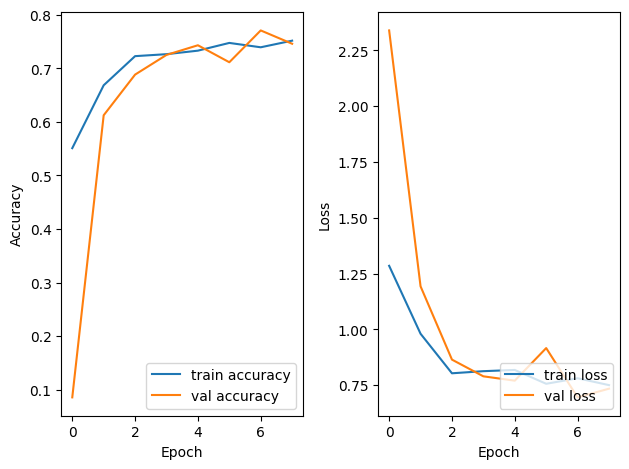

Test accuracy: 76.49%
Test loss: 0.743


100%|██████████| 119/119 [01:06<00:00,  1.79it/s]

Finished epoch 0 of 10: Train Loss = 0.629  Val Loss = 0.743   Train Acc = 0.788   Val Acc = 0.765



100%|██████████| 119/119 [01:06<00:00,  1.78it/s]

Finished epoch 1 of 10: Train Loss = 0.394  Val Loss = 0.644   Train Acc = 0.860   Val Acc = 0.814



100%|██████████| 119/119 [01:06<00:00,  1.80it/s]

Finished epoch 2 of 10: Train Loss = 0.230  Val Loss = 0.546   Train Acc = 0.925   Val Acc = 0.846



100%|██████████| 119/119 [01:06<00:00,  1.80it/s]

Finished epoch 3 of 10: Train Loss = 0.164  Val Loss = 0.487   Train Acc = 0.944   Val Acc = 0.862



100%|██████████| 119/119 [01:06<00:00,  1.79it/s]

Finished epoch 4 of 10: Train Loss = 0.103  Val Loss = 0.418   Train Acc = 0.965   Val Acc = 0.878



100%|██████████| 119/119 [01:06<00:00,  1.79it/s]

Finished epoch 5 of 10: Train Loss = 0.095  Val Loss = 0.389   Train Acc = 0.970   Val Acc = 0.880



100%|██████████| 119/119 [01:06<00:00,  1.80it/s]

Finished epoch 6 of 10: Train Loss = 0.075  Val Loss = 0.389   Train Acc = 0.979   Val Acc = 0.896



100%|██████████| 119/119 [01:06<00:00,  1.79it/s]

Finished epoch 7 of 10: Train Loss = 0.065  Val Loss = 0.375   Train Acc = 0.979   Val Acc = 0.890



100%|██████████| 119/119 [01:06<00:00,  1.80it/s]

Finished epoch 8 of 10: Train Loss = 0.052  Val Loss = 0.363   Train Acc = 0.985   Val Acc = 0.886



100%|██████████| 119/119 [01:06<00:00,  1.79it/s]

Finished epoch 9 of 10: Train Loss = 0.042  Val Loss = 0.365   Train Acc = 0.989   Val Acc = 0.899



100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


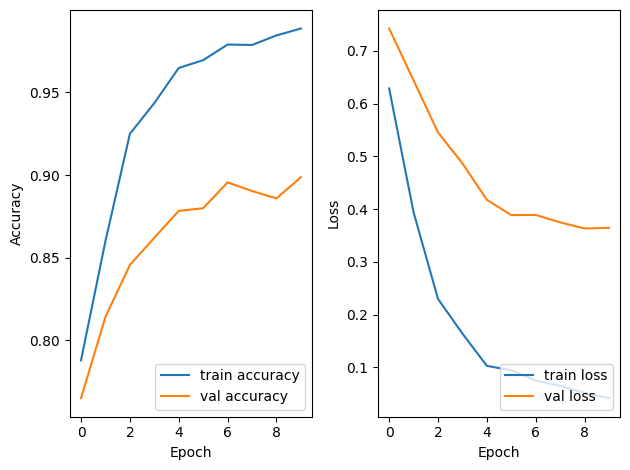

Test accuracy: 89.44%
Test loss: 0.363


In [ ]:
# densenet121 w/ augmentation 4
dn4 = pipeline(models.densenet121(pretrained=True))

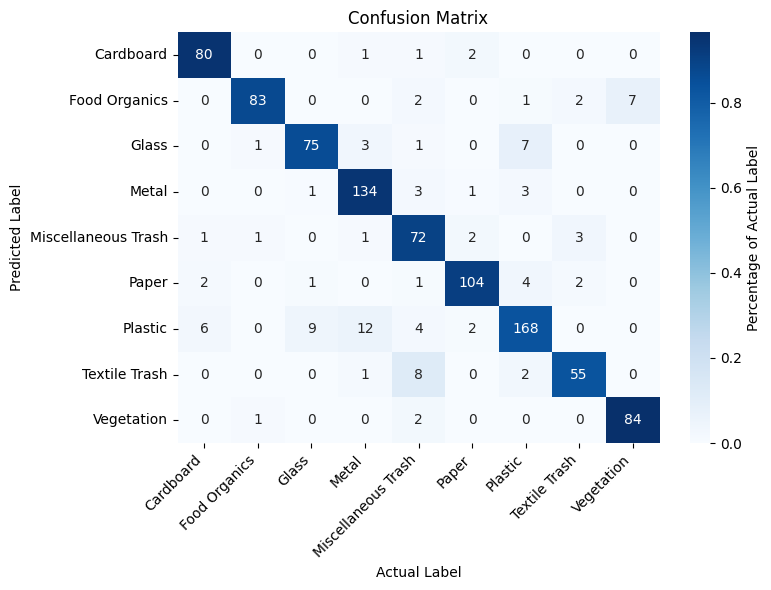


Accuracy: 0.8944
Class 0 (Cardboard): Precision: 0.9524, Recall: 0.8989, F1 Score: 0.9249
Class 1 (Food Organics): Precision: 0.8737, Recall: 0.9651, F1 Score: 0.9171
Class 2 (Glass): Precision: 0.8621, Recall: 0.8721, F1 Score: 0.8671
Class 3 (Metal): Precision: 0.9437, Recall: 0.8816, F1 Score: 0.9116
Class 4 (Miscellaneous Trash): Precision: 0.9000, Recall: 0.7660, F1 Score: 0.8276
Class 5 (Paper): Precision: 0.9123, Recall: 0.9369, F1 Score: 0.9244
Class 6 (Plastic): Precision: 0.8358, Recall: 0.9081, F1 Score: 0.8705
Class 7 (Textile Trash): Precision: 0.8333, Recall: 0.8871, F1 Score: 0.8594
Class 8 (Vegetation): Precision: 0.9655, Recall: 0.9231, F1 Score: 0.9438

Macro-Averaged Metrics:
Precision: 0.8976
Recall:    0.8932
F1 Score:  0.8940


In [ ]:
# evaluate dense121 w/ augmentation 4
evaluate_metrics(dn4, loader_test)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 94.4MB/s]
100%|██████████| 119/119 [17:29<00:00,  8.82s/it]

Finished epoch 0 of 8: Train Loss = 1.335  Val Loss = 2.353   Train Acc = 0.531   Val Acc = 0.090



100%|██████████| 119/119 [01:12<00:00,  1.65it/s]

Finished epoch 1 of 8: Train Loss = 1.071  Val Loss = 0.791   Train Acc = 0.649   Val Acc = 0.738



100%|██████████| 119/119 [01:08<00:00,  1.73it/s]

Finished epoch 2 of 8: Train Loss = 0.943  Val Loss = 0.944   Train Acc = 0.675   Val Acc = 0.686



100%|██████████| 119/119 [01:08<00:00,  1.73it/s]

Finished epoch 3 of 8: Train Loss = 0.931  Val Loss = 0.927   Train Acc = 0.688   Val Acc = 0.683



100%|██████████| 119/119 [01:08<00:00,  1.73it/s]

Finished epoch 4 of 8: Train Loss = 0.871  Val Loss = 0.804   Train Acc = 0.717   Val Acc = 0.726



100%|██████████| 119/119 [01:08<00:00,  1.73it/s]

Finished epoch 5 of 8: Train Loss = 0.905  Val Loss = 0.957   Train Acc = 0.694   Val Acc = 0.693



100%|██████████| 119/119 [01:08<00:00,  1.73it/s]

Finished epoch 6 of 8: Train Loss = 0.871  Val Loss = 0.973   Train Acc = 0.711   Val Acc = 0.715



100%|██████████| 119/119 [01:08<00:00,  1.73it/s]

Finished epoch 7 of 8: Train Loss = 0.886  Val Loss = 0.884   Train Acc = 0.703   Val Acc = 0.717



100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


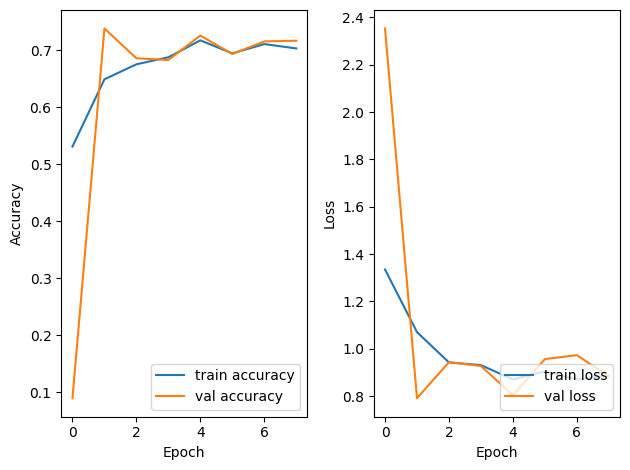

Test accuracy: 69.49%
Test loss: 0.915


100%|██████████| 119/119 [01:14<00:00,  1.59it/s]

Finished epoch 0 of 10: Train Loss = 0.791  Val Loss = 0.915   Train Acc = 0.746   Val Acc = 0.695



100%|██████████| 119/119 [01:14<00:00,  1.59it/s]

Finished epoch 1 of 10: Train Loss = 0.498  Val Loss = 0.676   Train Acc = 0.827   Val Acc = 0.783



100%|██████████| 119/119 [01:14<00:00,  1.60it/s]

Finished epoch 2 of 10: Train Loss = 0.348  Val Loss = 0.522   Train Acc = 0.873   Val Acc = 0.839



100%|██████████| 119/119 [01:15<00:00,  1.59it/s]

Finished epoch 3 of 10: Train Loss = 0.261  Val Loss = 0.351   Train Acc = 0.906   Val Acc = 0.882



100%|██████████| 119/119 [01:14<00:00,  1.59it/s]

Finished epoch 4 of 10: Train Loss = 0.195  Val Loss = 0.359   Train Acc = 0.934   Val Acc = 0.878



100%|██████████| 119/119 [01:14<00:00,  1.59it/s]

Finished epoch 5 of 10: Train Loss = 0.147  Val Loss = 0.331   Train Acc = 0.950   Val Acc = 0.900



100%|██████████| 119/119 [01:15<00:00,  1.58it/s]

Finished epoch 6 of 10: Train Loss = 0.119  Val Loss = 0.308   Train Acc = 0.962   Val Acc = 0.902



100%|██████████| 119/119 [01:15<00:00,  1.59it/s]

Finished epoch 7 of 10: Train Loss = 0.108  Val Loss = 0.283   Train Acc = 0.964   Val Acc = 0.905



100%|██████████| 119/119 [01:14<00:00,  1.59it/s]

Finished epoch 8 of 10: Train Loss = 0.092  Val Loss = 0.305   Train Acc = 0.970   Val Acc = 0.902



100%|██████████| 119/119 [01:14<00:00,  1.59it/s]

Finished epoch 9 of 10: Train Loss = 0.078  Val Loss = 0.268   Train Acc = 0.978   Val Acc = 0.914



100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


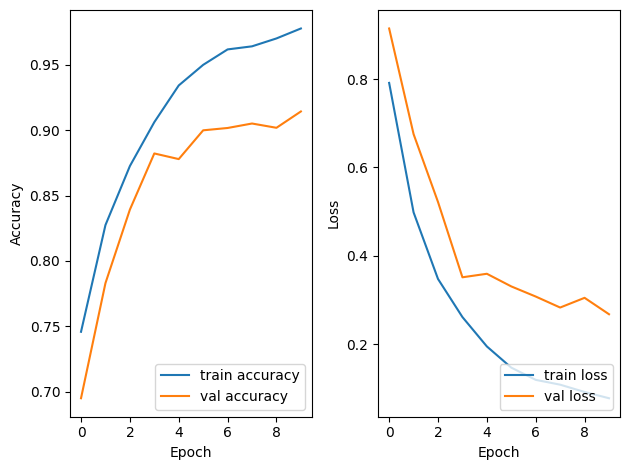

Test accuracy: 90.81%
Test loss: 0.301


In [ ]:
# densenet121 w/ augmentation 5
dn5 = pipeline(models.densenet121(pretrained=True))

In [ ]:
# evaluate dense121 w/ augmentation 5
evaluate_metrics(dn5, loader_test)

NameError: name 'dn5' is not defined

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 122MB/s] 
100%|██████████| 119/119 [19:43<00:00,  9.95s/it]

Finished epoch 0 of 8: Train Loss = 1.357  Val Loss = 2.312   Train Acc = 0.537   Val Acc = 0.107



100%|██████████| 119/119 [00:45<00:00,  2.64it/s]

Finished epoch 1 of 8: Train Loss = 0.973  Val Loss = 0.942   Train Acc = 0.664   Val Acc = 0.670



100%|██████████| 119/119 [00:41<00:00,  2.90it/s]

Finished epoch 2 of 8: Train Loss = 1.069  Val Loss = 0.698   Train Acc = 0.656   Val Acc = 0.748



100%|██████████| 119/119 [00:40<00:00,  2.92it/s]

Finished epoch 3 of 8: Train Loss = 1.010  Val Loss = 0.715   Train Acc = 0.669   Val Acc = 0.748



100%|██████████| 119/119 [00:40<00:00,  2.90it/s]

Finished epoch 4 of 8: Train Loss = 0.909  Val Loss = 0.745   Train Acc = 0.700   Val Acc = 0.736



100%|██████████| 119/119 [00:41<00:00,  2.86it/s]

Finished epoch 5 of 8: Train Loss = 0.891  Val Loss = 0.622   Train Acc = 0.710   Val Acc = 0.789



100%|██████████| 119/119 [00:41<00:00,  2.89it/s]

Finished epoch 6 of 8: Train Loss = 0.863  Val Loss = 0.614   Train Acc = 0.715   Val Acc = 0.781



100%|██████████| 119/119 [00:41<00:00,  2.87it/s]

Finished epoch 7 of 8: Train Loss = 0.852  Val Loss = 0.701   Train Acc = 0.712   Val Acc = 0.772



100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


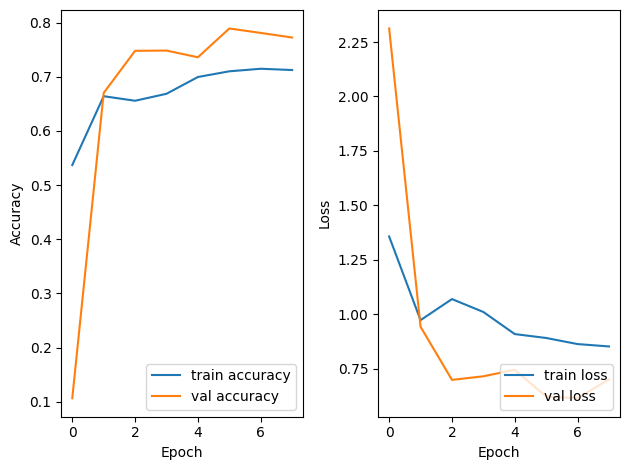

Test accuracy: 79.23%
Test loss: 0.593


100%|██████████| 119/119 [00:48<00:00,  2.47it/s]

Finished epoch 0 of 10: Train Loss = 0.775  Val Loss = 0.593   Train Acc = 0.743   Val Acc = 0.792



100%|██████████| 119/119 [00:47<00:00,  2.51it/s]

Finished epoch 1 of 10: Train Loss = 0.544  Val Loss = 0.554   Train Acc = 0.818   Val Acc = 0.820



100%|██████████| 119/119 [00:47<00:00,  2.51it/s]

Finished epoch 2 of 10: Train Loss = 0.387  Val Loss = 0.418   Train Acc = 0.868   Val Acc = 0.859



100%|██████████| 119/119 [00:47<00:00,  2.49it/s]

Finished epoch 3 of 10: Train Loss = 0.295  Val Loss = 0.363   Train Acc = 0.894   Val Acc = 0.880



100%|██████████| 119/119 [00:47<00:00,  2.52it/s]

Finished epoch 4 of 10: Train Loss = 0.244  Val Loss = 0.314   Train Acc = 0.911   Val Acc = 0.895



100%|██████████| 119/119 [00:47<00:00,  2.51it/s]

Finished epoch 5 of 10: Train Loss = 0.218  Val Loss = 0.331   Train Acc = 0.923   Val Acc = 0.891



100%|██████████| 119/119 [00:48<00:00,  2.48it/s]

Finished epoch 6 of 10: Train Loss = 0.162  Val Loss = 0.276   Train Acc = 0.951   Val Acc = 0.904



100%|██████████| 119/119 [00:47<00:00,  2.53it/s]

Finished epoch 7 of 10: Train Loss = 0.147  Val Loss = 0.290   Train Acc = 0.950   Val Acc = 0.898



100%|██████████| 119/119 [00:47<00:00,  2.51it/s]

Finished epoch 8 of 10: Train Loss = 0.151  Val Loss = 0.284   Train Acc = 0.948   Val Acc = 0.899



100%|██████████| 119/119 [00:47<00:00,  2.52it/s]

Finished epoch 9 of 10: Train Loss = 0.120  Val Loss = 0.273   Train Acc = 0.961   Val Acc = 0.905



100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


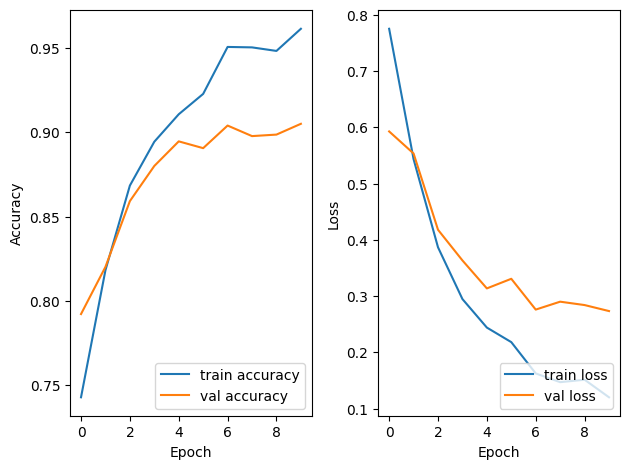

Test accuracy: 90.92%
Test loss: 0.263


In [ ]:
# densenet121 w/ augmentation 6
dn6 = pipeline(models.densenet121(pretrained=True))

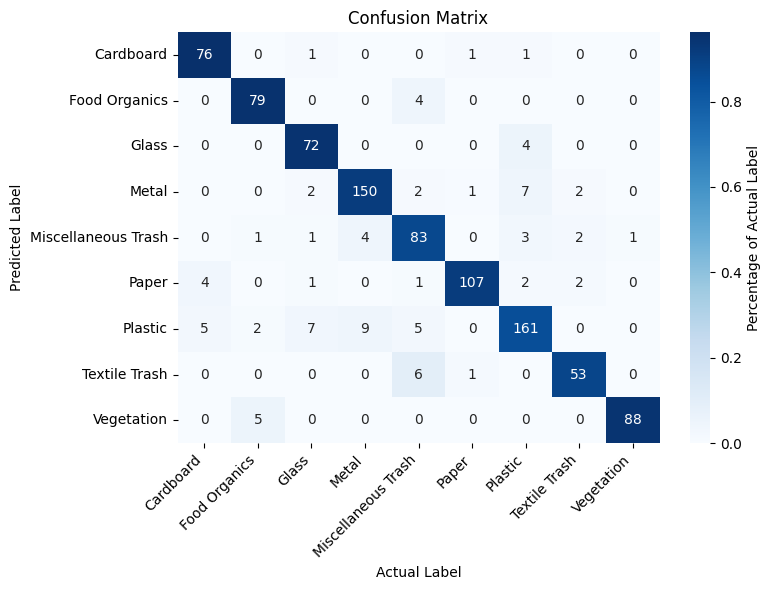


Accuracy: 0.9090
Class 0 (Cardboard): Precision: 0.9620, Recall: 0.8941, F1 Score: 0.9268
Class 1 (Food Organics): Precision: 0.9518, Recall: 0.9080, F1 Score: 0.9294
Class 2 (Glass): Precision: 0.9474, Recall: 0.8571, F1 Score: 0.9000
Class 3 (Metal): Precision: 0.9146, Recall: 0.9202, F1 Score: 0.9174
Class 4 (Miscellaneous Trash): Precision: 0.8737, Recall: 0.8218, F1 Score: 0.8469
Class 5 (Paper): Precision: 0.9145, Recall: 0.9727, F1 Score: 0.9427
Class 6 (Plastic): Precision: 0.8519, Recall: 0.9045, F1 Score: 0.8774
Class 7 (Textile Trash): Precision: 0.8833, Recall: 0.8983, F1 Score: 0.8908
Class 8 (Vegetation): Precision: 0.9462, Recall: 0.9888, F1 Score: 0.9670

Macro-Averaged Metrics:
Precision: 0.9162
Recall:    0.9073
F1 Score:  0.9109


In [ ]:
# evaluate dense121 w/ augmentation 6
evaluate_metrics(dn6, loader_test)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 119/119 [01:02<00:00,  1.90it/s]

Finished epoch 0 of 8: Train Loss = 1.343  Val Loss = 2.348   Train Acc = 0.534   Val Acc = 0.087



100%|██████████| 119/119 [01:02<00:00,  1.89it/s]

Finished epoch 1 of 8: Train Loss = 1.044  Val Loss = 0.864   Train Acc = 0.638   Val Acc = 0.685



100%|██████████| 119/119 [01:03<00:00,  1.89it/s]

Finished epoch 2 of 8: Train Loss = 0.949  Val Loss = 0.741   Train Acc = 0.674   Val Acc = 0.727



100%|██████████| 119/119 [01:02<00:00,  1.89it/s]

Finished epoch 3 of 8: Train Loss = 1.090  Val Loss = 0.799   Train Acc = 0.659   Val Acc = 0.735



100%|██████████| 119/119 [01:02<00:00,  1.89it/s]

Finished epoch 4 of 8: Train Loss = 0.941  Val Loss = 0.777   Train Acc = 0.688   Val Acc = 0.729



100%|██████████| 119/119 [01:03<00:00,  1.89it/s]

Finished epoch 5 of 8: Train Loss = 0.924  Val Loss = 0.716   Train Acc = 0.686   Val Acc = 0.754



100%|██████████| 119/119 [01:02<00:00,  1.90it/s]

Finished epoch 6 of 8: Train Loss = 0.895  Val Loss = 0.793   Train Acc = 0.698   Val Acc = 0.734



100%|██████████| 119/119 [01:03<00:00,  1.88it/s]

Finished epoch 7 of 8: Train Loss = 0.905  Val Loss = 0.760   Train Acc = 0.713   Val Acc = 0.754



100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


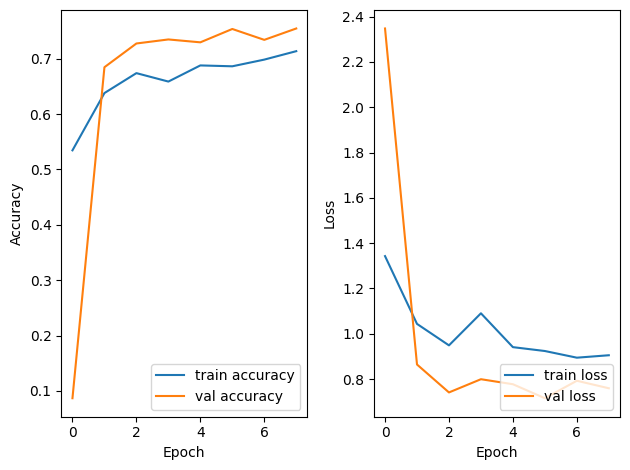

Test accuracy: 76.26%
Test loss: 0.685


100%|██████████| 119/119 [01:08<00:00,  1.73it/s]

Finished epoch 0 of 10: Train Loss = 0.800  Val Loss = 0.685   Train Acc = 0.738   Val Acc = 0.763



100%|██████████| 119/119 [01:09<00:00,  1.72it/s]

Finished epoch 1 of 10: Train Loss = 0.574  Val Loss = 0.616   Train Acc = 0.802   Val Acc = 0.805



100%|██████████| 119/119 [01:09<00:00,  1.71it/s]

Finished epoch 2 of 10: Train Loss = 0.406  Val Loss = 0.441   Train Acc = 0.861   Val Acc = 0.859



100%|██████████| 119/119 [01:08<00:00,  1.72it/s]

Finished epoch 3 of 10: Train Loss = 0.328  Val Loss = 0.441   Train Acc = 0.878   Val Acc = 0.863



100%|██████████| 119/119 [01:09<00:00,  1.72it/s]

Finished epoch 4 of 10: Train Loss = 0.291  Val Loss = 0.408   Train Acc = 0.897   Val Acc = 0.863



100%|██████████| 119/119 [01:08<00:00,  1.73it/s]

Finished epoch 5 of 10: Train Loss = 0.228  Val Loss = 0.384   Train Acc = 0.918   Val Acc = 0.871



100%|██████████| 119/119 [01:08<00:00,  1.73it/s]

Finished epoch 6 of 10: Train Loss = 0.207  Val Loss = 0.370   Train Acc = 0.925   Val Acc = 0.888



100%|██████████| 119/119 [01:09<00:00,  1.72it/s]

Finished epoch 7 of 10: Train Loss = 0.171  Val Loss = 0.319   Train Acc = 0.942   Val Acc = 0.900



100%|██████████| 119/119 [01:09<00:00,  1.71it/s]

Finished epoch 8 of 10: Train Loss = 0.168  Val Loss = 0.310   Train Acc = 0.944   Val Acc = 0.887



100%|██████████| 119/119 [01:09<00:00,  1.71it/s]

Finished epoch 9 of 10: Train Loss = 0.146  Val Loss = 0.335   Train Acc = 0.951   Val Acc = 0.901



 67%|██████▋   | 10/15 [00:06<00:03,  1.59it/s]

In [ ]:
# densenet121 w/ augmentation 7
dn7 = pipeline(models.densenet121(pretrained=True))

In [ ]:
# evaluate dense121 w/ augmentation 7
evaluate_metrics(dn7, loader_test)